<a href="https://colab.research.google.com/github/Team-AlmaBetter/Retail-Sales-Prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

#<b>Import necessary libraries

In [ ]:
import pandas as pd, datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# <b>2.Data Preparation

##<b>2.1 Import Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Retail Sales Prediction-Capstone 2/Data & Resources/Rossmann Stores Data.csv')
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
train.shape

(1017209, 9)

In [ ]:
store = pd.read_csv('/content/drive/MyDrive/Retail Sales Prediction-Capstone 2/Data & Resources/store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store.shape

(1115, 10)

#<B>2.2 Dealing With Missing Values 

##<b>2.2.1 Count missing values in each dataset

In [ ]:
print("train:\n\n", train.isnull().sum(),  
     "\n\nstore:\n\n", store.isnull().sum())

train:

 Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64 

store:

 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


##<b>2.2.2 Remove features with high percentages of missing values

We can see that some features have a high percentage of missing values and they won't be accurate as indicators, so we will remove features with more than 30% missing values.

In [ ]:
# remove features
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval'], axis=1)

In [ ]:
print('Distinct number of Stores:', len(data['Store'].unique()))
print('Distinct number of Dates:', len(data['Date'].unique()))
print('Average daily sales of all Stores:', round(data['Sales'].mean(), 2))

Distinct number of Stores: 1115
Distinct number of Dates: 942
Average daily sales of all Stores: 5773.82


In [ ]:
data['DayOfWeek'].value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

In [ ]:
len(data)

1017209

# Handling Bias Data

In [ ]:
# We will remove the part of the datasets,where stores are closed, they won't generate sales
data=data[data.Open != 0]

In [ ]:
# Check for Opened store with zero sales
data[data.Sales==0]['Store'].sum()

31460

In [ ]:
# percentage of open stored with zero sales
data[data.Sales == 0]['Sales'].sum()/data.Sales.sum()

0.0

In [ ]:
# Remove the Stores with zero sales
data=data[data.Sales != 0]

Checking the nominal values

In [ ]:
# Nominal Values
set(data.StateHoliday),set(data.Assortment),set(data.StoreType)

({0, '0', 'a', 'b', 'c'}, {'a', 'b', 'c'}, {'a', 'b', 'c', 'd'})

Since StateHoliday have zero for none.
let's convert that into string '0'

In [ ]:
# converting 0 to string '0'
data.loc[data.StateHoliday == 0,'StateHoliday'] = data.loc[data.StateHoliday == 0,'StateHoliday'].astype(str)

#<B>Create new columns related to Dates


In [ ]:
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format = True)

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter
data['Week'] = data['Date'].dt.week
data['Day'] = data['Date'].dt.day

data['Season'] = np.where(data['Month'].isin([3,4,5]), "Spring",
                 np.where(data['Month'].isin([6,7,8]), "Summer",
                 np.where(data['Month'].isin([9,10,11]), "Fall",
                 np.where(data['Month'].isin([12,1,2]), "Winter", "None"))))

In [ ]:
data.iloc[:,-6:].head()

,Year,Month,Quarter,Week,Day,Season
0,2015,7,3,31,31,Summer
1,2015,7,3,31,30,Summer
2,2015,7,3,31,29,Summer
3,2015,7,3,31,28,Summer
4,2015,7,3,31,27,Summer


### Create new variable "AvgSales" 

i am currently working on it

In [ ]:
# data[['Year','Month','Store','Sales']].groupby(['Year','Month','Store']).mean().head(25)

# Correlation Heatmap


In [ ]:
corr = data.corr()
corr

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Quarter,Week,Day
Store,1.000000,0.000343,0.007723,0.033991,NaN,-0.000015,0.000526,-0.027045,-0.051080,-0.005014,0.007728,0.010686,0.037994,0.000300,0.001371,0.001407,0.001297,-0.000127
DayOfWeek,0.000343,1.000000,-0.178753,-0.097266,NaN,-0.289268,-0.139319,0.005542,0.000387,0.001262,-0.003252,-0.000581,0.003387,0.002099,-0.019710,-0.016170,-0.014389,0.008525
Sales,0.007723,-0.178753,1.000000,0.823552,NaN,0.368199,0.038635,-0.036453,-0.043472,0.016102,-0.127556,0.095212,-0.034595,0.036151,0.073589,0.062000,0.074463,-0.051865
Customers,0.033991,-0.097266,0.823552,1.000000,NaN,0.182859,0.024915,-0.148569,-0.044949,0.010174,-0.202207,0.061585,0.041017,-0.000842,0.053843,0.047185,0.053763,-0.035416
Open,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Promo,-0.000015,-0.289268,0.368199,0.182859,NaN,1.000000,0.028971,-0.002392,-0.000130,-0.000196,-0.000316,-0.001210,-0.002185,0.023990,-0.006412,-0.003358,0.006947,-0.126442
SchoolHoliday,0.000526,-0.139319,0.038635,0.024915,NaN,0.028971,1.000000,-0.004279,-0.000446,0.000559,-0.008244,-0.003960,-0.003451,-0.038686,0.118467,0.166850,0.079584,0.038085
CompetitionDistance,-0.027045,0.005542,-0.036453,-0.148569,NaN,-0.002392,-0.004279,1.000000,-0.059936,0.027963,-0.141977,-0.053487,-0.111017,0.000625,0.003844,0.003664,0.003655,-0.000228
CompetitionOpenSinceMonth,-0.051080,0.000387,-0.043472,-0.044949,NaN,-0.000130,-0.000446,-0.059936,1.000000,-0.060734,-0.010595,-0.036149,0.049458,-0.000795,-0.001432,-0.001399,-0.001402,0.000103
CompetitionOpenSinceYear,-0.005014,0.001262,0.016102,0.010174,NaN,-0.000196,0.000559,0.027963,-0.060734,1.000000,-0.077229,-0.080096,0.012574,0.001008,0.004300,0.004334,0.004127,-0.000325


Text(0.5, 1.0, 'Correlation Heatmap')

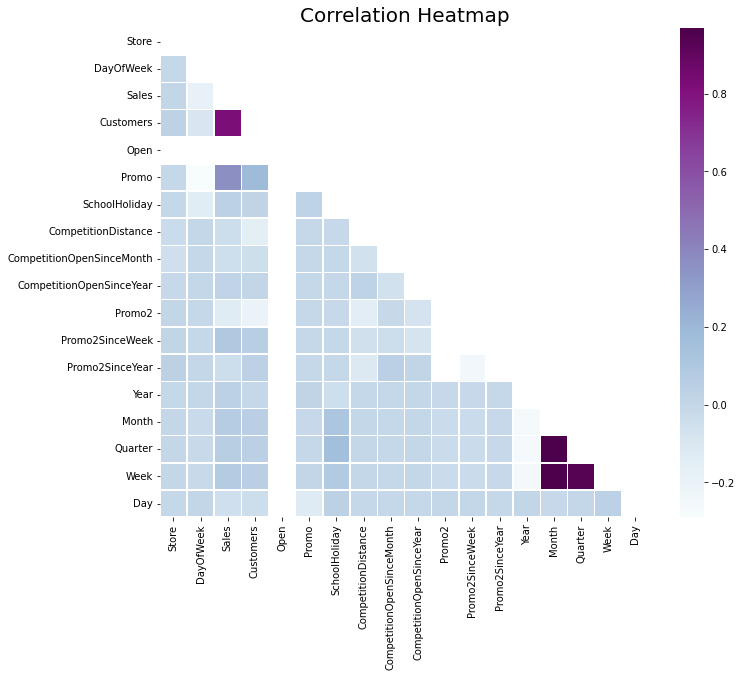

In [ ]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (11, 9))
# sns.heatmap(corr, mask = mask,square = True, linewidths = .5, ax = ax, cmap = "BuPu")
sns.heatmap(corr,square = True,mask=mask, linewidths = .5,ax=ax, cmap = "BuPu")
plt.title("Correlation Heatmap", fontsize=20)

#<b>Exploratory Data Analysis & Visualization

In [ ]:
data.describe (include= 'all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Quarter,Week,Day,Season
count,844338.000000,844338.000000,844338,844338.000000,844338.000000,844338.0,844338.000000,844338,844338.000000,844338,844338,842152.000000,575738.000000,575738.000000,844338.000000,421046.000000,421046.000000,421046,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,4,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,4
top,NaN,NaN,2015-06-09 00:00:00,NaN,NaN,NaN,NaN,0,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct",NaN,NaN,NaN,NaN,NaN,Spring
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,843428,NaN,457042,444875,NaN,NaN,NaN,NaN,NaN,NaN,242397,NaN,NaN,NaN,NaN,NaN,247800
first,NaN,NaN,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2015-07-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,558.421374,3.520350,NaN,6955.959134,762.777166,1.0,0.446356,NaN,0.193578,NaN,NaN,5458.156627,7.224842,2008.697753,0.498670,23.254177,2011.753929,NaN,2013.831945,5.845774,2.296006,23.646946,15.835706,NaN
std,321.730861,1.723712,NaN,3103.815515,401.194153,0.0,0.497114,NaN,0.395102,NaN,NaN,7809.573181,3.210118,5.978064,0.499999,14.100647,1.660946,NaN,0.777271,3.323959,1.083494,14.389931,8.683392,NaN
min,1.000000,1.000000,NaN,46.000000,8.000000,1.0,0.000000,NaN,0.000000,NaN,NaN,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,NaN,2013.000000,1.000000,1.000000,1.000000,1.000000,NaN
25%,280.000000,2.000000,NaN,4859.000000,519.000000,1.0,0.000000,NaN,0.000000,NaN,NaN,710.000000,4.000000,2006.000000,0.000000,13.000000,2011.000000,NaN,2013.000000,3.000000,1.000000,11.000000,8.000000,NaN


In [ ]:
data.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
Year                                  int64
Month                                 int64
Quarter                               int64
Week                                  int64
Day                             

In [ ]:
# days on which store closed, with zero sales has to be removed
# closed_stores = data[data['Open'] == 0]. index
# data.drop (closed_stores, inplace=True)

In [ ]:
# checking for missing values
data.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
Year                              0
Month                             0
Quarter                           0
Week                              0
Day                               0
Season                            0
dtype: int64

In [ ]:
# adding column of SalesperCustomer
data['SalesperCustomer'] = data['Sales']/data['Customers']
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Quarter,Week,Day,Season,SalesperCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,3,31,31,Summer,9.482883
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,3,31,30,Summer,9.194139
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,3,31,29,Summer,9.143403
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,3,31,28,Summer,8.948214
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,3,31,27,Summer,9.970588


In [ ]:
# filling competition distance with mean
data['CompetitionDistance'].fillna(data['CompetitionDistance'].mean(), inplace = True)


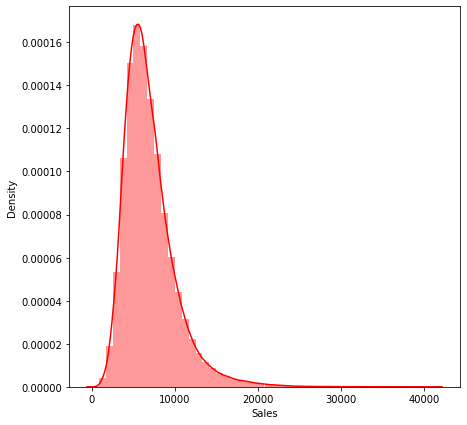

In [ ]:
#plotting dependent variable "Sales"
plt.figure(figsize = (7,7))
sns.distplot(data['Sales'], color='r')

Positively skewed, log transformation reqd

## Store Type vs Different features

Text(0.5, 1.0, 'Average Spending per Customer in each Store Type \n Fig 1.6')

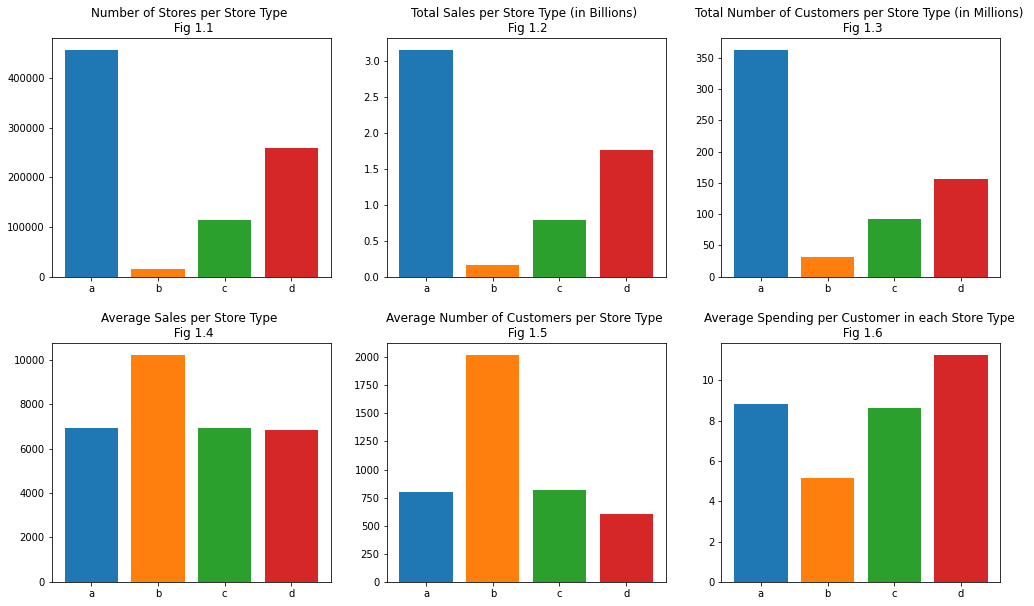

In [ ]:
fig, axes = plt.subplots(2, 3,figsize=(17,10) )
palette = itertools.cycle(sns.color_palette(n_colors=4))
plt.subplots_adjust(hspace = 0.28)
#axes[1].df_train_store.groupby(by="StoreType").count().Store.plot(kind='bar')
axes[0,0].bar(data.groupby(by="StoreType").count().Store.index,data.groupby(by="StoreType").count().Store,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,0].set_title("Number of Stores per Store Type \n Fig 1.1")
axes[0,1].bar(data.groupby(by="StoreType").sum().Sales.index,data.groupby(by="StoreType").sum().Sales/1e9,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,1].set_title("Total Sales per Store Type (in Billions) \n Fig 1.2")
axes[0,2].bar(data.groupby(by="StoreType").sum().Customers.index,data.groupby(by="StoreType").sum().Customers/1e6,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,2].set_title("Total Number of Customers per Store Type (in Millions) \n Fig 1.3")
axes[1,0].bar(data.groupby(by="StoreType").sum().Customers.index,data.groupby(by="StoreType").Sales.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,0].set_title("Average Sales per Store Type \n Fig 1.4")
axes[1,1].bar(data.groupby(by="StoreType").sum().Customers.index,data.groupby(by="StoreType").Customers.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,1].set_title("Average Number of Customers per Store Type \n Fig 1.5")
axes[1,2].bar(data.groupby(by="StoreType").sum().Sales.index,data.groupby(by="StoreType").SalesperCustomer.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,2].set_title("Average Spending per Customer in each Store Type \n Fig 1.6")



## Sales trend over the months and year

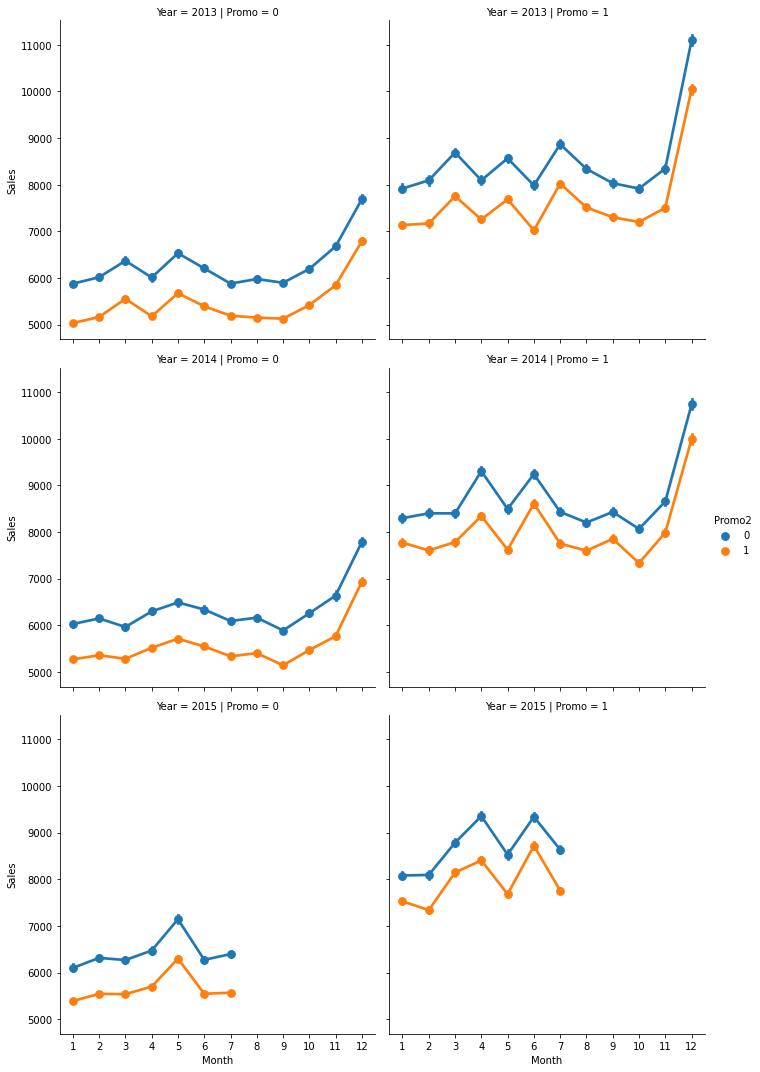

In [ ]:
# Sales trend over the months and year
sns.factorplot(data = data, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year")

## Sales trend over the months and year

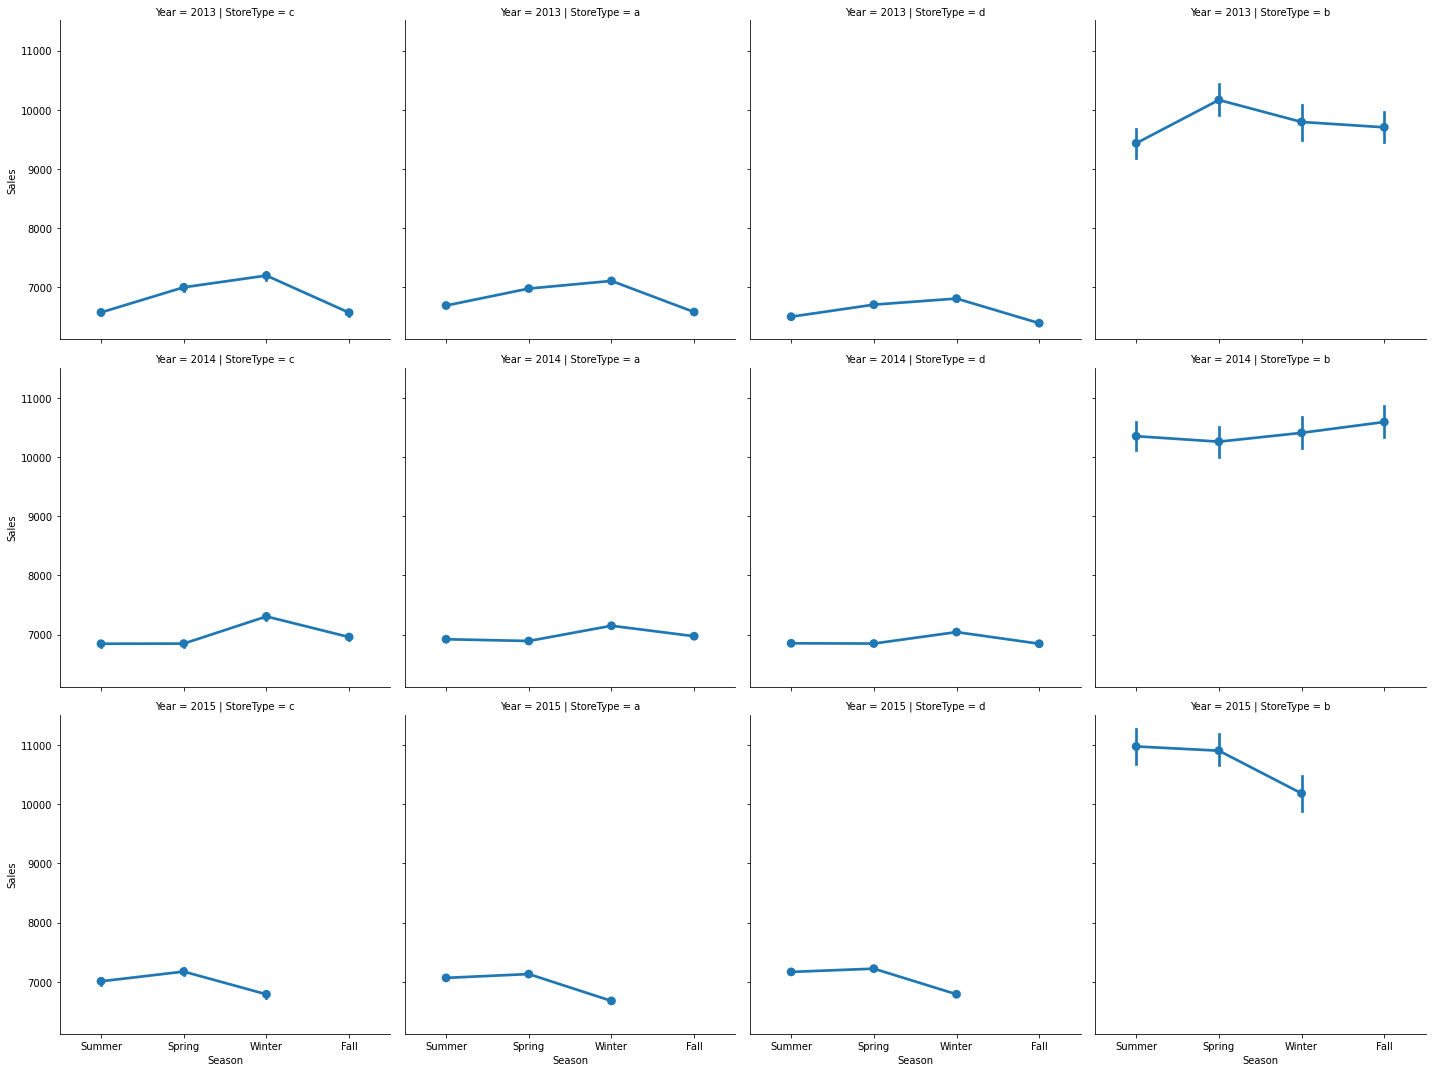

In [ ]:
# Sales trend over the seasons and year
sns.factorplot(data = data, x ="Season", y = "Sales", 
               col = 'StoreType',
               row = "Year")

## Sales over days and months for different Assortment

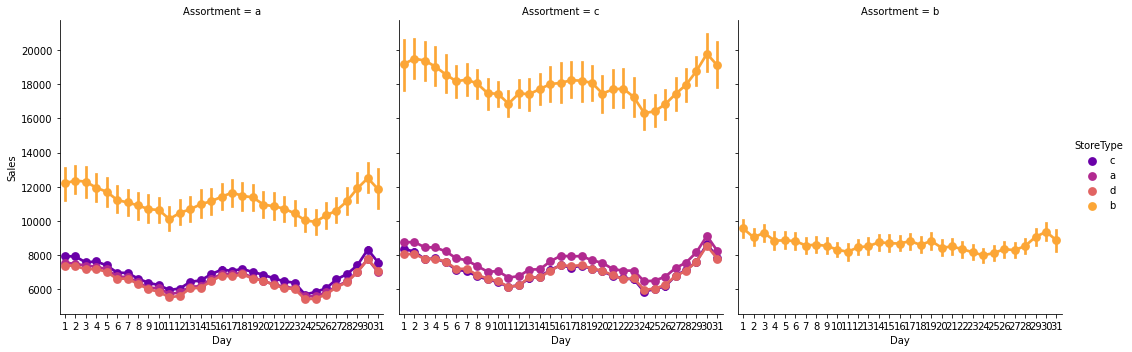

In [ ]:
# Sales over days of different Assortment
sns.factorplot(data = data, x ="Day", y = "Sales", 
               col = 'Assortment',
               palette = 'plasma',
               hue = 'StoreType')

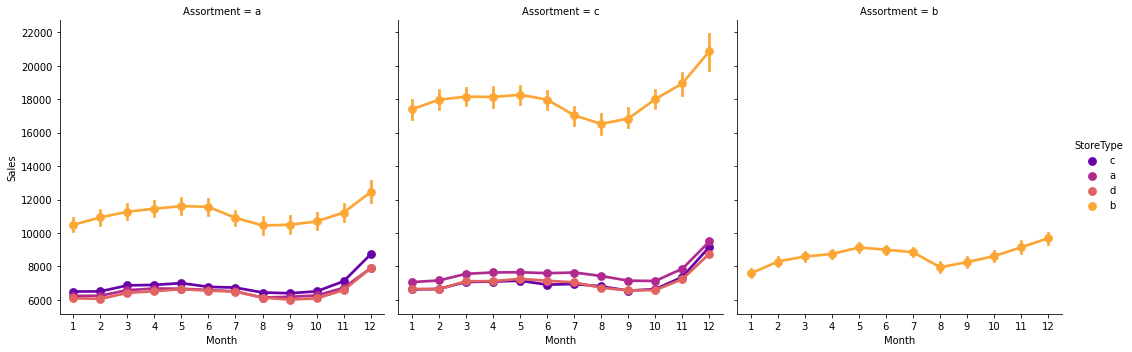

In [ ]:
# Sales By Month of Different Assorment
sns.factorplot(data = data, x = 'Month', y = "Sales", 
               col = 'Assortment',
               palette = 'plasma',
               hue = 'StoreType')

## Sales Per Day



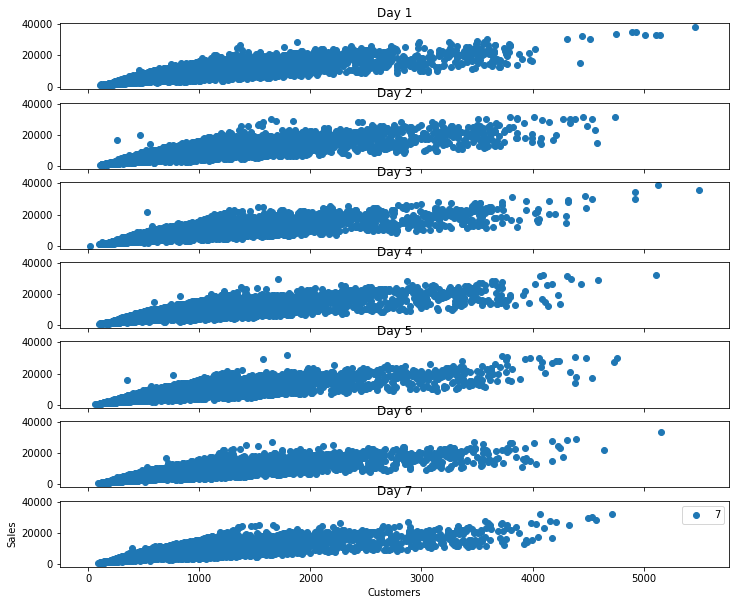

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)
f, ax = plt.subplots(7, sharex=True, sharey=True)
plt.rcParams['figure.figsize'] = (10.0, 50.0)
for i in range(1, 8):
  mask = data[data['Day'] == i]
  ax[i - 1].set_title("Day {0}".format(i))
  ax[i - 1].scatter(mask['Customers'], mask['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.savefig('output1.png', dpi=300, bbox_inches='tight')
plt.show()

## Sales per Customer

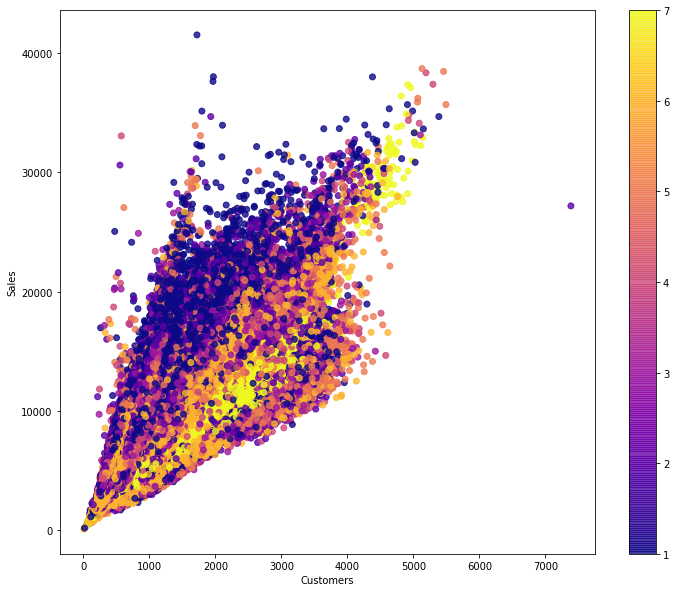

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)
plt.scatter(data['Customers'], data['Sales'], c=data['DayOfWeek'], alpha=0.8, cmap=plt.cm.get_cmap('plasma'))
plt.colorbar()
plt.xlabel('Customers')
plt.ylabel('Sales')
# plt.savefig('output2.png', dpi=300, bbox_inches='tight')
plt.show()
